# Frente de Pareto
**Evaluación de conformaciones de CDK2 según su valor de AUC con el dataset CSAR**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Carga de los datos.

In [2]:
# Carga y muestra de los datos
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")
df_cdk2_labels.iloc[: , -8:].head(5)

,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,STU,440.0,inact_b,0.730317,0.740724,0.575339,0.634163,0.572172
1b38,ATP,398.0,inact_a,0.677828,0.683258,0.546154,0.571946,0.483032
1b39,ATP,398.0,inact_a,0.764706,0.785520,0.580543,0.670814,0.607919
1buh,,,inact_a,0.708145,0.734163,0.535294,0.613348,0.544344
1ckp,PVB,214.0,inact_a,0.766968,0.781900,0.571493,0.764932,0.715385


## Correlación de los rankings
### Correlación de Pearson y Spearman

In [3]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina', 'AUC_vrd_8x', 'AUC_vrd_16x']]


Para obtener la correlación de los valores:

In [4]:
# Correlación de Pearson
mtx_cor_pearson = df_auc_scores.corr(method = 'pearson')
# Correlación de Spearman
mtx_cor_sepearman = df_auc_scores.corr(method = 'spearman')

In [5]:
mtx_cor_pearson

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
AUC_ad4_LE,1.000000,0.897545,0.292637,0.616034,0.620263
AUC_ad4_LC,0.897545,1.000000,0.268382,0.624657,0.631929
AUC_vina,0.292637,0.268382,1.000000,0.531182,0.523890
AUC_vrd_8x,0.616034,0.624657,0.531182,1.000000,0.955277
AUC_vrd_16x,0.620263,0.631929,0.523890,0.955277,1.000000


In [6]:
mtx_cor_sepearman

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
AUC_ad4_LE,1.000000,0.905884,0.273622,0.615868,0.617034
AUC_ad4_LC,0.905884,1.000000,0.265574,0.642429,0.647881
AUC_vina,0.273622,0.265574,1.000000,0.520171,0.494863
AUC_vrd_8x,0.615868,0.642429,0.520171,1.000000,0.950113
AUC_vrd_16x,0.617034,0.647881,0.494863,0.950113,1.000000


#### No obstante, para extraer los valores p, usaremos scipy

In [7]:
# Extraemos el valor de correlación y el valor p entre cada par
n_values = df_auc_scores.shape[1]
# Creamos las matrices vacias
mtx_pearson_p = np.zeros((n_values, n_values))
mtx_spearman_p = np.zeros((n_values, n_values))

for i, i_data in enumerate(df_auc_scores):
    for j, j_data in enumerate(df_auc_scores):
        # Cálculo de Pearson
        r_P, p_P = stats.pearsonr(df_auc_scores[i_data], 
                               df_auc_scores[j_data])
        mtx_pearson_p[i, j] = p_P
        # Cálculo de Pearson
        r_S, p_S = stats.spearmanr(df_auc_scores[i_data], 
                       df_auc_scores[j_data])
        mtx_spearman_p[i, j] = p_S

In [8]:
# p-values
# H0: El coeficiente de correlación NO es diferente de 0 (muestras son independientes)
# Ha: r es distinto de cero (Muestras dependientes/ correlacionadas)

# Verificamos que los valores de correlación sean significativos
print(mtx_pearson_p.all() < 0.05)

print(mtx_spearman_p.all() < 0.05)
# Todos los valores p son menores a alfa = 0.05

True
True


## Gráfica de las correlaciones

In [9]:
import seaborn as sns
%matplotlib inline
sns.set( context = 'notebook', style = 'white', font_scale=1.2)

### Pairplot

In [10]:
# Añadimos una etiqueta a las conformaciones tal que podamos distinguir las activas de las inactivas
# Creamos las etiquetas
labels = ['CDK2 Activa' if i == 'active' else 'CDK Inactiva' for i in df_cdk2_labels.Labels_conf]
# La añadimos al dataframe
df_auc_scores_labels = df_auc_scores.copy()
df_auc_scores_labels['Labels'] = labels

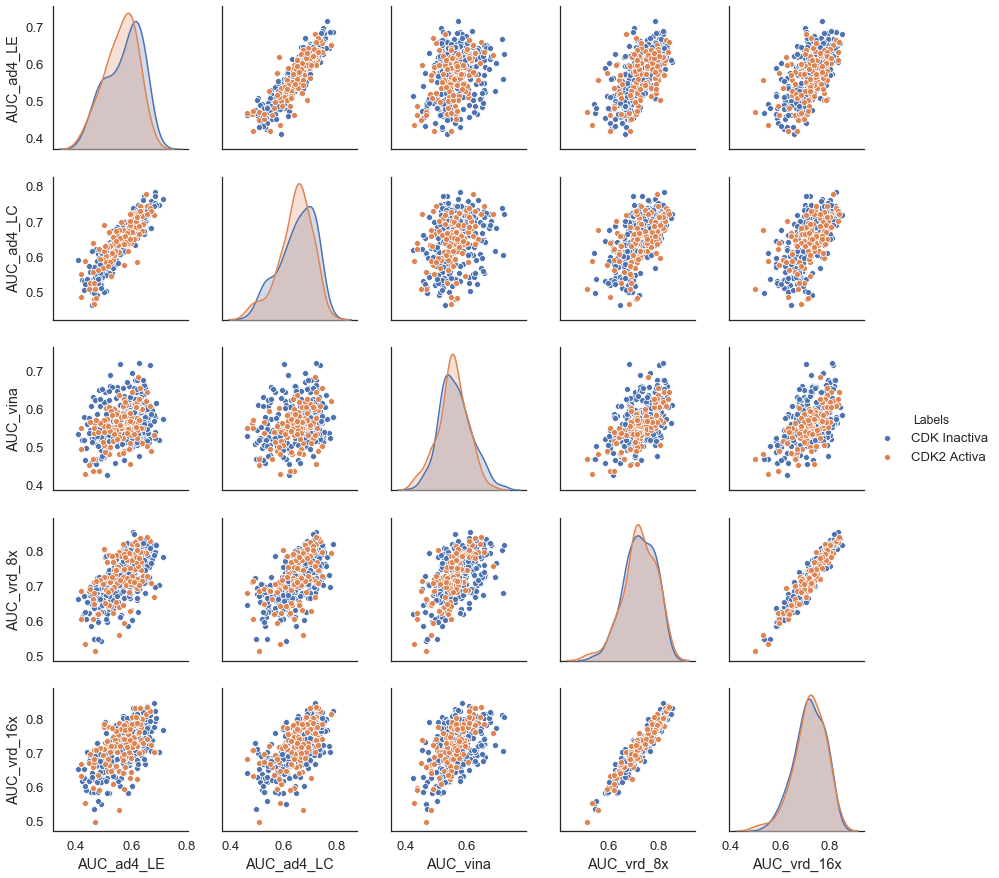

In [11]:
#plt.figure(figsize=(10, 10))
pair_plot = sns.pairplot(df_auc_scores_labels, hue = 'Labels')
pair_plot;

> **La eqtiqueta del tipo de conformación no permite visualizar ningun patrón, no obstante quizá con posteriores análisis podamos identificar patrones en las conformaciones con mejor AUC, que permitan visualizar una distinción de éstas con respecto a las conformaciones con menor AUC.**

#### PENDIENTE:
Verificar si el volumen, la forma del pocket, un subconjunto de residuos de la proteína o quizá alguna otra característica de éstas permiten determinar qué las hace buenas para haber mejorado el ranking.

# Frente de Pareto

### Función para identificar las observaciones del frente no dominado

In [12]:
def pareto_front(scores):
    ''' Función para determinar si una observación pertenece 
    al frente no dominado dado un arreglo de scores de las funciones objetivo.
    '''
    # Se crea un arreglo inicial de tamaño igual al número de observaciones
    # Todos los elementos se inicializan como parte del frente no dominado
    pareto_front = np.ones(scores.shape[0], dtype = bool)
    # Se itera sobre los scores de cada observación
    for i, s in enumerate(scores):
        # Comprueba si el score (s) de i domina a los demás elementos
        pareto_front[i] = np.all(np.any(scores[:i] < s, axis=1)) and np.all(np.any(scores[i+1:] < s, axis=1))
    return pareto_front

Recordar que en el dataframe `df_auc_scores` tenemos los AUC de los diferentes métodos de acomplamiento/scores.

### Primer ejemplo:
    - AUC de vinardo 8x
    - AUC de AD4 LC

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
1h07,0.686199,0.784842,0.578054,0.819683,0.825113
1urw,0.604525,0.722172,0.609955,0.851584,0.831674
4cfn,0.665837,0.738914,0.607919,0.826244,0.824208
4eor,0.633032,0.729864,0.626697,0.836878,0.832127


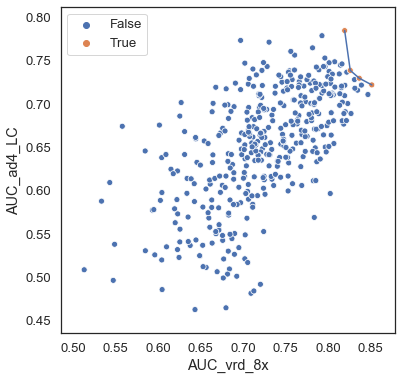

In [13]:
# Generamos un arreglo de numpy con los scores deseados
scores = df_auc_scores[['AUC_vrd_8x', 'AUC_ad4_LC']].to_numpy()
pareto_points = pareto_front(scores)
# Graficamos
plt.figure(figsize=(6, 6))
sns.scatterplot(df_auc_scores['AUC_vrd_8x'], df_auc_scores['AUC_ad4_LC'], hue=pareto_points)
df_pareto = df_auc_scores[pareto_points]
sns.lineplot(df_pareto['AUC_vrd_8x'], df_pareto['AUC_ad4_LC'])
df_auc_scores[pareto_points]

### Segundo ejemplo:
    - AUC de vinardo 8x
    - AUC de vinardo |6x

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
1urw,0.604525,0.722172,0.609955,0.851584,0.831674
2r3p,0.656335,0.716063,0.605204,0.834842,0.839819
2vv9,0.680543,0.719005,0.584163,0.815837,0.848643
6guf,0.658371,0.721946,0.644344,0.839367,0.836878


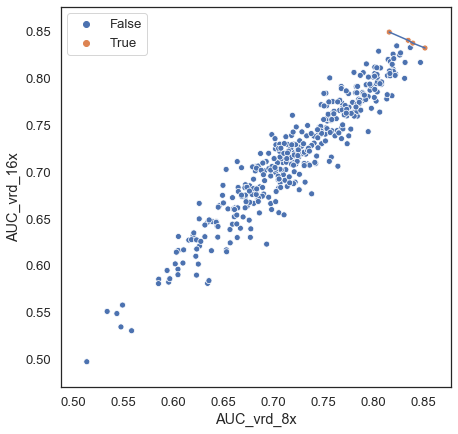

In [14]:
# Generamos un arreglo de numpy con los scores deseados
ejemplo_scores = df_auc_scores[['AUC_vrd_8x', 'AUC_vrd_16x']].to_numpy()
pareto_points = pareto_front(ejemplo_scores)
# Graficamos
plt.figure(figsize=(7, 7))
sns.scatterplot(df_auc_scores['AUC_vrd_8x'], df_auc_scores['AUC_vrd_16x'], hue = pareto_points)
df_pareto = df_auc_scores[pareto_points]
sns.lineplot(df_pareto['AUC_vrd_8x'], df_pareto['AUC_vrd_16x'])
df_auc_scores[pareto_points]

## Todos los scores (5 objetivos)
### Conformaciones en el frente no dominado

In [22]:
# Generamos un arreglo de numpy con los scores deseados
scores = df_auc_scores.to_numpy()
pareto_points = pareto_front(scores)
confs = df_auc_scores[pareto_points].index
print(F'Número de conformaciones el el frente no dominado: {len(confs)}')
confs

Número de conformaciones el el frente no dominado: 25


Index(['1ckp', '1h07', '1ke9', '1oiq', '1pxm', '1urw', '1vyz', '2c4g', '2r3p',
       '2r64', '2vv9', '2w05', '3eid', '3ezv', '3lfn', '3qu0', '3s0o', '3s2p',
       '3unj', '3unk', '4bzd', '4cfn', '4eor', '4fkq', '6guf'],
      dtype='object')

In [25]:
# Generamos un arreglo de numpy con los scores deseados
scores = df_auc_scores[['AUC_vrd_16x', 'AUC_ad4_LC', 'AUC_vina', 'AUC_ad4_LE']].to_numpy()
pareto_points = pareto_front(scores)
confs = df_auc_scores[pareto_points].index
print(F'Número de conformaciones el el frente no dominado: {len(confs)}')
df_auc_scores[pareto_points].index

Número de conformaciones el el frente no dominado: 19


Index(['1ckp', '1h07', '1oiq', '1vyz', '2c4g', '2r3p', '2r64', '2vv9', '2w05',
       '3eid', '3ezv', '3s2p', '3unj', '3unk', '4bzd', '4cfn', '4eor', '4fkq',
       '6guf'],
      dtype='object')

In [24]:
# Generamos un arreglo de numpy con los scores deseados
scores = df_auc_scores[['AUC_vrd_8x', 'AUC_ad4_LC', 'AUC_vina', 'AUC_ad4_LE']].to_numpy()
pareto_points = pareto_front(scores)
confs = df_auc_scores[pareto_points].index
print(F'Número de conformaciones el el frente no dominado: {len(confs)}')
df_auc_scores[pareto_points].index

Número de conformaciones el el frente no dominado: 22


Index(['1ckp', '1h07', '1ke9', '1oiq', '1pxm', '1urw', '2c4g', '2r64', '2w05',
       '3eid', '3ezv', '3lfn', '3qu0', '3s0o', '3s2p', '3unj', '3unk', '4bzd',
       '4cfn', '4eor', '4fkq', '6guf'],
      dtype='object')